# PSPNet Model
In this notebook, we develop the Pyramid Scene Parsing network (based on https://github.com/Lextal/pspnet-pytorch), along with ResNet pretrainerd model.

In [1]:
!pip install keras-segmentation

In [4]:
from datetime import datetime
from functools import partial
import glob
from multiprocessing import Pool

# Disable multiprocesing for numpy/opencv. We already multiprocess ourselves, this would mean every subprocess produces
# even more threads which would lead to a lot of context switching, slowing things down a lot.
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm, tqdm_notebook
import scipy
import scipy.ndimage
import scipy.special
from scipy.spatial.transform import Rotation as R

from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection.mAP_evaluation import Box3D

In [1]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

In [2]:
# Credits
# Model implementation based on https://github.com/Lextal/pspnet-pytorch

# Data Augmentation
Here is some code for augmenting data. We are not using this yet, but we believe scaling, cropping, padding, changing color hues would be a great way to extend the data and improve model predictions.

In [3]:
import random
import numbers
import math
import collections

from PIL import ImageOps, Image
import numpy as np


class Padding:
    def __init__(self, pad):
        self.pad = pad

    def __call__(self, img):
        return ImageOps.expand(img, border=self.pad, fill=0)


class Scale:
    def __init__(self, size, interpolation=Image.NEAREST):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation

    def __call__(self, imgmap):
        img, target = imgmap
        if isinstance(self.size, int):
            w, h = img.size
            if (w <= h and w == self.size) or (h <= w and h == self.size):
                return img, target
            if w < h:
                ow = self.size
                oh = int(self.size * h / w)
                return img.resize((ow, oh), self.interpolation), target.resize((ow, oh), self.interpolation)
            else:
                oh = self.size
                ow = int(self.size * w / h)
                return img.resize((ow, oh), self.interpolation), target.resize((ow, oh), self.interpolation)
        else:
            return img.resize(self.size, self.interpolation), target.resize(self.size, self.interpolation)


class CenterCrop:
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgmap):
        img, target = imgmap
        w, h = img.size
        th, tw = self.size
        x1 = int(round((w - tw) / 2.))
        y1 = int(round((h - th) / 2.))
        return img.crop((x1, y1, x1 + tw, y1 + th)), target.crop((x1, y1, x1 + tw, y1 + th))


class RandomCrop:
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, imgmap):
        img, target = imgmap
        w, h = img.size
        if self.size is not None:
            th, tw = self.size
            if w == tw and h == th:
                return img, target
            else:
                x1 = random.randint(0, w - tw)
                y1 = random.randint(0, h - th)
            return img.crop((x1, y1, x1 + tw, y1 + th)), target.crop((x1, y1, x1 + tw, y1 + th))
        else:
            return img, target


class RandomSizedCrop:

    def __init__(self, size, interpolation=Image.NEAREST):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, imgmap):
        img, target = imgmap
        for attempt in range(10):
            area = img.size[0] * img.size[1]
            target_area = random.uniform(0.5, 1.0) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img.size[0] and h <= img.size[1]:
                x1 = random.randint(0, img.size[0] - w)
                y1 = random.randint(0, img.size[1] - h)

                img = img.crop((x1, y1, x1 + w, y1 + h))
                target = target.crop((x1, y1, x1 + w, y1 + h))
                assert(img.size == (w, h))
                assert(target.size == (w, h))

                return img.resize((self.size, self.size), self.interpolation), \
                       target.resize((self.size, self.size), self.interpolation)

        # Fallback
        scale = Scale(self.size, interpolation=self.interpolation)
        crop = CenterCrop(self.size)
        return crop(scale((img, target)))


class RandomHorizontalFlip:

    def __call__(self, imgmap):
        img, target = imgmap
        if random.random() < 0.5:
            return img.transpose(Image.FLIP_LEFT_RIGHT), target.transpose(Image.FLIP_LEFT_RIGHT)
        return img, target


class RandomRotation:

    def __call__(self, imgmap, degree=10):
        img, target = imgmap
        deg = np.random.randint(-degree, degree, 1)[0]
        return img.rotate(deg), target.rotate(deg)

# Data Loader
We have already prepared our dataset. For local training and testing, we have split our training set 50/50, into training and validation. This allows us to validate our results locally and have a smaller dataset to train against.

Once we are certain, we will train our model on the full dataset for Kaggke submission.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

# Use for Full training
# train_data_folder = '/home/hsb2140/deep-learnging-3d-object-dectation/input/lyft3d-mask-test-data/bev_train_data'

# Use for Local training (train/validation) split 50/50 - data already split 50/50 and stored
train_data_folder = '/home/hsb2140/artifacts/bev_train_data'

class BEVImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_filepaths, target_filepaths, map_filepaths=None):
        self.input_filepaths = input_filepaths
        self.target_filepaths = target_filepaths
        self.map_filepaths = map_filepaths
        
        if map_filepaths is not None:
            assert len(input_filepaths) == len(map_filepaths)
        
        assert len(input_filepaths) == len(target_filepaths)

    def __len__(self):
        return len(self.input_filepaths)

    def __getitem__(self, idx):
        input_filepath = self.input_filepaths[idx]
        target_filepath = self.target_filepaths[idx]
        
        sample_token = input_filepath.split("/")[-1].replace("_input.png","")
        
        im = cv2.imread(input_filepath, cv2.IMREAD_UNCHANGED)
        
        if self.map_filepaths:
            map_filepath = self.map_filepaths[idx]
            map_im = cv2.imread(map_filepath, cv2.IMREAD_UNCHANGED)
            im = np.concatenate((im, map_im), axis=2)
        
        target = cv2.imread(target_filepath, cv2.IMREAD_UNCHANGED)
        
        im = im.astype(np.float32)/255
        target = target.astype(np.int64)
        
        im = torch.from_numpy(im.transpose(2,0,1))
        target = torch.from_numpy(target)
        
        return im, target, sample_token

input_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_input.png")))
target_filepaths = sorted(glob.glob(os.path.join(train_data_folder, "*_target.png")))

train_dataset = BEVImageDataset(input_filepaths, target_filepaths)
    
im, target, sample_token = train_dataset[1]
im = im.numpy()
target = target.numpy()

plt.figure(figsize=(16,8))

<Figure size 1152x576 with 0 Axes>

<Figure size 1152x576 with 0 Axes>

# Model

In [5]:
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import model_zoo
from torchvision.models.densenet import densenet121, densenet161
from torchvision.models.squeezenet import squeezenet1_1


def load_weights_sequential(target, source_state):
    model_to_load= {k: v for k, v in source_state.items() if k in target.state_dict().keys()}
    target.load_state_dict(model_to_load)

'''
    Implementation of dilated ResNet-101 with deep supervision. Downsampling is changed to 8x
'''
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, dilation=dilation, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride=stride, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes, stride=1, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, dilation=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, dilation=dilation,
                               padding=dilation, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers=(3, 4, 23, 3)):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x_3 = self.layer3(x)
        x = self.layer4(x_3)

        return x, x_3


'''
    Implementation of DenseNet with deep supervision. Downsampling is changed to 8x 
'''


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate):
        super(_DenseLayer, self).__init__()
        self.add_module('norm.1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu.1', nn.ReLU(inplace=True)),
        self.add_module('conv.1', nn.Conv2d(num_input_features, bn_size *
                                            growth_rate, kernel_size=1, stride=1, bias=False)),
        self.add_module('norm.2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu.2', nn.ReLU(inplace=True)),
        self.add_module('conv.2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                            kernel_size=3, stride=1, padding=1, bias=False)),
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = super(_DenseLayer, self).forward(x)
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, drop_rate)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, downsample=True):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        if downsample:
            self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))
        else:
            self.add_module('pool', nn.AvgPool2d(kernel_size=1, stride=1))  # compatibility hack


class DenseNet(nn.Module):
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, pretrained=True):

        super(DenseNet, self).__init__()

        # First convolution
        self.start_features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features

        init_weights = list(densenet121(pretrained=True).features.children())
        start = 0
        for i, c in enumerate(self.start_features.children()):
            if pretrained:
                c.load_state_dict(init_weights[i].state_dict())
            start += 1
        self.blocks = nn.ModuleList()
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features,
                                bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate)
            if pretrained:
                block.load_state_dict(init_weights[start].state_dict())
            start += 1
            self.blocks.append(block)
            setattr(self, 'denseblock%d' % (i + 1), block)

            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                downsample = i < 1
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                    downsample=downsample)
                if pretrained:
                    trans.load_state_dict(init_weights[start].state_dict())
                start += 1
                self.blocks.append(trans)
                setattr(self, 'transition%d' % (i + 1), trans)
                num_features = num_features // 2

    def forward(self, x):
        out = self.start_features(x)
        deep_features = None
        for i, block in enumerate(self.blocks):
            out = block(out)
            if i == 5:
                deep_features = out

        return out, deep_features


class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes, dilation=1):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=dilation, dilation=dilation)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)


class SqueezeNet(nn.Module):

    def __init__(self, pretrained=False):
        super(SqueezeNet, self).__init__()

        self.feat_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.feat_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64)
        )
        self.feat_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            Fire(128, 32, 128, 128, 2),
            Fire(256, 32, 128, 128, 2)
        )
        self.feat_4 = nn.Sequential(
            Fire(256, 48, 192, 192, 4),
            Fire(384, 48, 192, 192, 4),
            Fire(384, 64, 256, 256, 4),
            Fire(512, 64, 256, 256, 4)
        )
        if pretrained:
            weights = squeezenet1_1(pretrained=True).features.state_dict()
            load_weights_sequential(self, weights)

    def forward(self, x):
        f1 = self.feat_1(x)
        f2 = self.feat_2(f1)
        f3 = self.feat_3(f2)
        f4 = self.feat_4(f3)
        return f4, f3


'''
    Handy methods for construction
'''


def squeezenet(pretrained=True):
    return SqueezeNet(pretrained)


def densenet(pretrained=True):
    return DenseNet(pretrained=pretrained)


def resnet18(pretrained=True):
    model = ResNet(BasicBlock, [2, 2, 2, 2])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet18']))
    return model


def resnet34(pretrained=True):
    model = ResNet(BasicBlock, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=True):
    model = ResNet(Bottleneck, [3, 4, 23, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet101']))
    return model


def resnet152(pretrained=True):
    model = ResNet(Bottleneck, [3, 8, 36, 3])
    if pretrained:
        load_weights_sequential(model, model_zoo.load_url(model_urls['resnet152']))
    return model

extractors = {}
extractors['squeezenet'] = squeezenet
extractors['densenet'] = densenet
extractors['resnet18'] = resnet18
extractors['resnet34'] = resnet34
extractors['resnet50'] = resnet50
extractors['resnet101'] = resnet101
extractors['resnet152'] = resnet152

In [6]:
import torch
from torch import nn
from torch.nn import functional as F

class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(1, 2, 3, 6)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class PSPUpsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.PReLU()
        )

    def forward(self, x):
        h, w = 2 * x.size(2), 2 * x.size(3)
        p = F.upsample(input=x, size=(h, w), mode='bilinear')
        return self.conv(p)


class PSPNet(nn.Module):
    def __init__(self, n_classes=18, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet34',
                 pretrained=True):
        super().__init__()
#         self.feats = getattr(extractors, backend)(pretrained)
        self.feats = extractors[backend](pretrained)
        self.psp = PSPModule(psp_size, 1024, sizes)
        self.drop_1 = nn.Dropout2d(p=0.3)

        self.up_1 = PSPUpsample(1024, 256)
        self.up_2 = PSPUpsample(256, 64)
        self.up_3 = PSPUpsample(64, 64)

        self.drop_2 = nn.Dropout2d(p=0.15)
        self.final = nn.Sequential(
            nn.Conv2d(64, n_classes, kernel_size=1),
            nn.LogSoftmax()
        )

        self.classifier = nn.Sequential(
            nn.Linear(deep_features_size, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        f, class_f = self.feats(x) 
        p = self.psp(f)
        p = self.drop_1(p)

        p = self.up_1(p)
        p = self.drop_2(p)

        p = self.up_2(p)
        p = self.drop_2(p)

        p = self.up_3(p)
        p = self.drop_2(p)

        auxiliary = F.adaptive_max_pool2d(input=class_f, output_size=(1, 1)).view(-1, class_f.size(1))

        return self.final(p), self.classifier(auxiliary)

This custom RAdm optimizer is borrowed from the baseline U-NET model; it allows us to more efficiently optimize without using up too much memory.

In [7]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

# Training

In [7]:
import torch

# We weigh the loss for the 0 class lower to account for (some of) the big class imbalance.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = torch.from_numpy(np.array([0.2] + [1.0]*len(classes), dtype=np.float32))
class_weights = class_weights.to(device)
print(device)

cuda


In [9]:
import os

from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.autograd import Variable
from torch.utils.data import DataLoader

from tqdm import tqdm
import numpy as np

models = {
    'squeezenet': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='squeezenet'),
    'densenet': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=1024, deep_features_size=512, backend='densenet'),
    'resnet18': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet18'),
    'resnet34': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=512, deep_features_size=256, backend='resnet34'),
    'resnet50': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet50'),
    'resnet101': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet101'),
    'resnet152': lambda: PSPNet(n_classes=len(classes)+1, sizes=(1, 2, 3, 6), psp_size=2048, deep_features_size=1024, backend='resnet152')
}

def build_network(snapshot, backend):
    epoch = 0
    backend = backend.lower()
    net = models[backend]()
    net = nn.DataParallel(net)
    if snapshot is not None:
        _, epoch = os.path.basename(snapshot).split('_')
        epoch = int(epoch)
        net.load_state_dict(torch.load(snapshot))
        logging.info("Snapshot for epoch {} loaded from {}".format(epoch, snapshot))
    net = net.cuda()
    return net, epoch


backend='resnet34'
snapshot=None
crop_x=256 
crop_y=256
batch_size=16
alpha=0.01
epochs=15
milestones='10,20,30'
gpu='0'

net, starting_epoch = build_network(snapshot, backend)

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=os.cpu_count()*2)

'''
    To follow this training routine you need a DataLoader that yields the tuples of the following format:
    (Bx3xHxW FloatTensor x, BxHxW LongTensor y, BxN LongTensor y_cls) where
    x - batch of input images,
    y - batch of groung truth seg maps,
    y_cls - batch of 1D tensors of dimensionality N: N total number of classes, 
    y_cls[i, T] = 1 if class T is present in image i, 0 otherwise
'''
train_loader, class_weights, n_images = None, None, None

all_losses = []
optim = RAdam(net.parameters(), lr=1e-3)
        

# Train

In [10]:
for epoch in range(epochs):
    print("Epoch", epoch)
    
    progress_bar = tqdm_notebook(dataloader)

#     seg_criterion = nn.NLLLoss2d(weight=class_weights)
#     cls_criterion = nn.BCEWithLogitsLoss(weight=class_weights)
    epoch_losses = []
    net.train()
    for ii, (X, target, sample_ids) in enumerate(progress_bar):
        optim.zero_grad()
        
        X = X.to(device)  # [N, 3, H, W]
        target = target.to(device)  # [N, H, W] with class indices (0, 1)
        prediction, out_cls = net(X)  # [N, 2, H, W]
        
#         seg_loss, cls_loss = seg_criterion(out, y), cls_criterion(out_cls, y_cls)
#         loss = seg_loss + alpha * cls_loss
        loss = F.cross_entropy(prediction, target, weight=class_weights)
    
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        epoch_losses.append(loss.detach().cpu().numpy())

    print("Loss:", np.mean(epoch_losses))
    all_losses.extend(epoch_losses)

    checkpoint_filename = "1_pspnet_checkpoint_epoch_{}.pth".format(epoch)
    checkpoint_filepath = os.path.join('/home/hsb2140/', checkpoint_filename)
    torch.save(net.state_dict(), checkpoint_filepath)
#     train_loss = np.mean(epoch_losses)


Epoch 0


/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/hsb2140/miniconda3/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Loss: 0.24649781
Epoch 1



Loss: 0.019393962
Epoch 2



Loss: 0.013151167
Epoch 3



Loss: 0.010835841
Epoch 4



Loss: 0.009487289
Epoch 5


KeyboardInterrupt: 

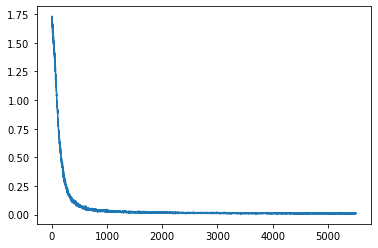

In [14]:
import matplotlib.pyplot as plt
plt.plot(all_losses)

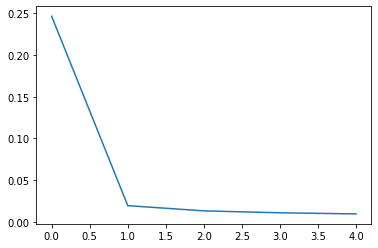

In [16]:
losses = [0.24649781,0.019393962,0.013151167,0.010835841, 0.009487289]
import matplotlib.pyplot as plt
plt.plot(losses)